In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import Resnet
from scipy.ndimage import rotate
import tensorflow.keras.backend as K
import Utils
import cv2

2022-10-31 18:26:18.256207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data_root = '../../data/'
def filtered_labels(path, columns = ['skin_tone','gender','age']):
    df = pd.read_csv(data_root + path)
    if columns is not None and len(columns) > 0:
        df = df.dropna(how='any',subset=columns)
        
    df['skin_tone'] = df.skin_tone.apply(lambda x: int(x.replace('monk_',''))-1)
    df['gender'] = df.gender.apply(lambda x: int(x == 'male'))
    age_map = {
        '0_17': 0,
        '18_30': 1,
        '31_60': 2,
        '61_100': 3,
    }
    df['age'] = df.age.apply(lambda x: age_map[x])
    return df
train_labels = filtered_labels('train_labels.csv')
test_labels = filtered_labels('labels.csv')

train_labels

name  skin_tone  gender  age
1      TRAIN0001.png          0       0    1
2      TRAIN0002.png          5       1    0
4      TRAIN0004.png          2       1    0
5      TRAIN0005.png          1       1    0
6      TRAIN0006.png          1       0    1
...              ...        ...     ...  ...
12276  TRAIN9993.png          1       1    1
12278  TRAIN9995.png          8       0    1
12279  TRAIN9996.png          3       0    1
12281  TRAIN9998.png          4       1    1
12282  TRAIN9999.png          3       1    1

[8553 rows x 4 columns]

In [3]:

class Augmentor():
    
    def __init__(self,noise_sigma=.03):
        self.noise_sigma = noise_sigma
        
    def random_range(self,min_ratio = .25, max_ratio = .9):
        return max(min(max_ratio,1.5*np.random.random()), min_ratio)
    
    def random_crop(self,img):
        ratio = self.random_range()
        crop_size = [int(img.shape[0]*ratio), int(img.shape[1]*ratio)]
        assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
        img = img.copy()
        w, h = img.shape[:2]
        x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
        img = img[y:y+crop_size[0], x:x+crop_size[1]]
        return img
    
    def random_rotation(self,img, bg_patch=(5,5)):
        assert len(img.shape) <= 3, "Incorrect image shape"
        angle = (self.random_range(.25,.75)*360 - 180)
        rgb = len(img.shape) == 3
        if rgb:
            bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
        else:
            bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
        img = rotate(img, angle,reshape=False)
        mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
        img[mask] = bg_color
        return img
    
    def gaussian_noise(self,img, mean=0):
        img = img.copy()
        noise = (np.random.normal(mean, self.noise_sigma, img.shape)*255).astype(np.uint8)
        mask_overflow_upper = img+noise >= 255
        mask_overflow_lower = img+noise < 0
        noise[mask_overflow_upper] = 255
        noise[mask_overflow_lower] = 0

        img += noise
        return img
    
    
    def color_shift(self,img):
        img = img.copy().astype(np.float32)
        for channel in [0,1,2]:
            img[channel] *= .5 + self.random_range(.1,.9)
        img = img.astype(np.uint8)
        return img
    
    def augment_image(self,img,crop=True,rotate=True,noise=True,color_shift=False):
        shape = img.shape
        if crop:
            img = self.random_crop(img)
        if rotate:
            img = self.random_rotation(img)
        if noise:
            img = self.gaussian_noise(img)
        if color_shift:
            img = self.color_shift(img)
            
        img = cv2.resize(img,[shape[0],shape[1]])
        return img
    
    def augment_images(self,images,**kwargs):
        images = np.stack([self.augment_image(i,**kwargs) for i in images])
        return self.format_images(images)
    
    def format_images(self,images,normalize=True,whiten=True):
        images = images.astype(np.float32)
        if whiten:
            images = Utils.prewhiten(images)
        if normalize:
            images = Utils.l2_normalize(images)
        images = (images - images.min())/(images.max() - images.min())
        return images
    
augmentor = Augmentor()
test_images = np.stack([keras.preprocessing.image.load_img(data_root + n) for n in train_labels.iloc[0:10].name])
temp_images = augmentor.augment_images(test_images)
temp_images

array([[[[0.76026034, 0.37485734, 0.09182698],
         [0.7805283 , 0.3975662 , 0.0989856 ],
         [0.7492193 , 0.39432836, 0.07961372],
         ...,
         [0.6805623 , 0.28113112, 0.08830225],
         [0.7035077 , 0.37176618, 0.06165988],
         [0.7925558 , 0.47440454, 0.09533064]],

        [[0.7235904 , 0.43961763, 0.05687171],
         [0.73600996, 0.4297474 , 0.06483882],
         [0.7300588 , 0.41407   , 0.06446543],
         ...,
         [0.71213406, 0.39623713, 0.05928037],
         [0.6899338 , 0.43386516, 0.04223075],
         [0.7549289 , 0.3788916 , 0.08727082]],

        [[0.7282733 , 0.430121  , 0.06067146],
         [0.72962457, 0.4462127 , 0.05911357],
         [0.7314795 , 0.4338334 , 0.0617757 ],
         ...,
         [0.7251211 , 0.4150451 , 0.06170271],
         [0.69806933, 0.40699232, 0.05042298],
         [0.69299585, 0.3617524 , 0.05995274]],

        ...,

        [[0.6664871 , 0.29527563, 0.07529851],
         [0.6795192 , 0.30293643, 0.07698675]

In [4]:
class FaceGenerator(keras.preprocessing.image.ImageDataGenerator):
    
    def __init__(self,df,root,
                 filter=True,
                 batch_size=200,
                 labels=None,
                 regularize_labels=False,
                 validation_split=.2,
                 shuffle=True,
                 **kwargs):
        super(FaceGenerator,self).__init__()
        self.df = df.copy()
        
        self.batch_size = batch_size
        self.current_step = 0
        self.root=root
        self.shuffle=shuffle
        self.labels = labels if (labels is not None) else ['skin_tone','age','gender']
        self.n_classes = {label: len(self.df[label].unique()) for label in self.labels}
        self.validation_df = None
        self.augmentor = Augmentor(**kwargs)
        if validation_split > 0:
            self.validation_df = self.df.sample(frac=validation_split,random_state=0)
            self.df = self.df.drop(self.validation_df.index,axis=0)
        if regularize_labels:
            self.df[self.labels] = self.df[self.labels].values/self.df[self.labels].max().values
        self.n_images = self.df.shape[0]
        self.n_batches = self.n_images/self.batch_size
        if self.n_batches != int(self.n_batches):
            self.n_batches = int(self.n_batches) + 1
        else:
            self.n_batches = int(self.n_batches)
        self.reset()
            
    def batch_subset(self):
        start = (self.current_step)*self.batch_size
        stop = start + self.batch_size
        subset = self.df.iloc[start:stop,:]
        self.current_step += 1
        if self.current_step >= self.n_batches:
            self.reset()
        return subset
    
    def reset(self):
        self.current_step = 0
        if self.shuffle:
            self.df = self.df.sample(frac=1)
    
    def process_image_file(self,i):
        image = keras.preprocessing.image.load_img(self.root+i)
        return image#tf.convert_to_tensor(image)
    
    def get_images(self,files):
        images = [self.process_image_file(f) for f in files]
        images = np.stack(images)
        return images
#         return (images - images.mean(axis=0))/images.std()
    
    def get_batch(self,**kwargs):
        subdf = self.batch_subset()
        return self.process_files(subdf,**kwargs)
    
    def get_validation(self,**kwargs):
        if self.validation_df is not None:
            return self.process_files(self.validation_df,**kwargs)
        else:
            print('no validation data')
            
    def get_dataset(self):
        return self.process_files(self.df)
    
    def process_files(self,subdf,augment_images=True,as_tensor=False,**kwargs):
        #will return a list of arrays [images, label1, label2, label3, etc]
        images = self.get_images(subdf.name.values)
        if augment_images:
            images = self.augmentor.augment_images(images,**kwargs)
        labels = [np.eye(self.n_classes[label])[subdf[label].values] for label in self.labels]
        if as_tensor:
            images = tf.convert_to_tensor(images,dtype=tf.float32)
            labels = [tf.convert_to_tensor(l) for l in labels]
        output = [images, labels]
        return output
    
train_dataset = FaceGenerator(train_labels,data_root)
[batch_x, batch_y] = train_dataset.get_batch(as_tensor=False)
batch_y

[array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.

In [5]:
[y.shape for y in batch_y]

[(200, 10), (200, 4), (200, 2)]

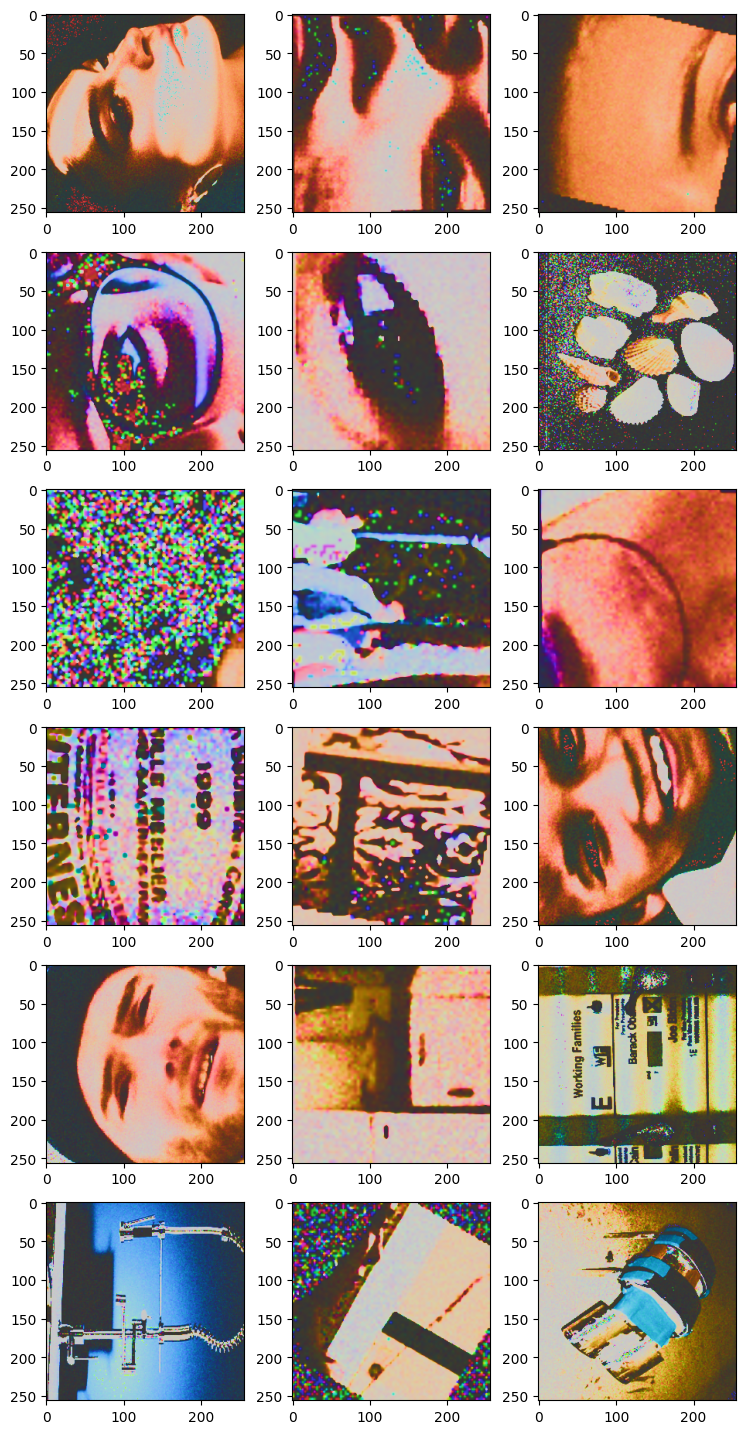

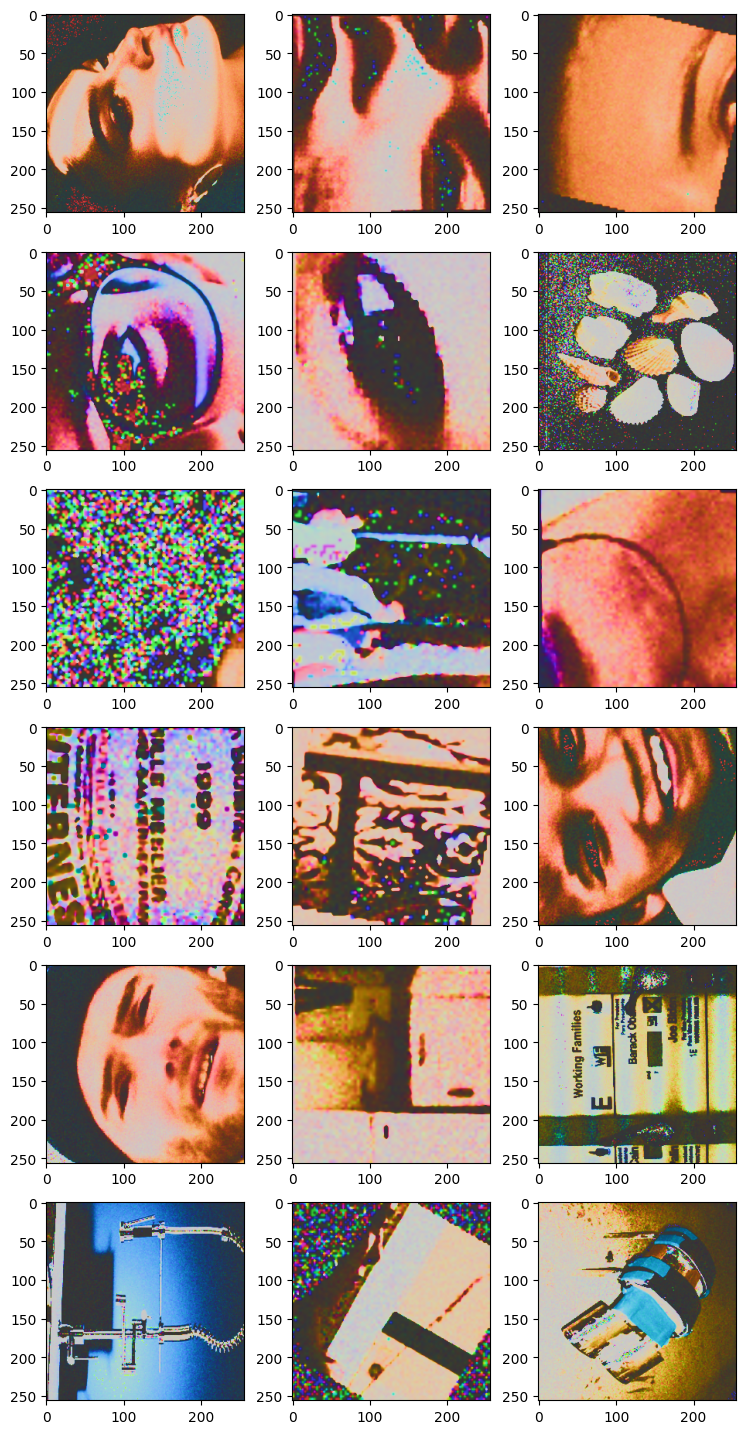

In [6]:
def plot_selection(images,rows=6,columns=3):
    fig = plt.figure(figsize=(3*columns, 3*rows))
    # setting values to rows and column variables
    for i in range(rows*columns):
        image = images[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(image)
        
    return fig
plot_selection(batch_x)

In [24]:
facenet = Resnet.InceptionResNetV1(input_shape=(256,256,3),weights_path='models/facenet_keras_weights.h5')
facenet.summary()

2022-10-31 18:32:50.269310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1669] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:6a:00.0
2022-10-31 18:32:50.269383: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-31 18:32:50.269480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-31 18:32:50.269492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-10-31 18:32:50.269501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-10-31 18:32:50.269510: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2022-10-31 18:32:50.269521: I tensorflow/stream_executor/platform/default/ds

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 127, 127, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 127, 127, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [25]:
test = facenet.predict_on_batch(np.stack(temp_images))
test.shape

(10, 128)

In [44]:
def get_facenet_subset(fnet, level = 'add_18',dropout=.2,embedding=128):
    #level can be add 21-add 40, add 41 will just ouput original resnet
    inputs = fnet.inputs
    base = keras.Model(inputs = inputs, outputs = fnet.get_layer(level).output)
    x = keras.layers.GlobalAveragePooling2D(name='AvgPool')(base.layers[-1].output)
    x = keras.layers.Dropout(dropout, name='Dropout')(x)
    x = keras.layers.Dense(embedding, use_bias=False, name='Bottleneck')(x)
    bn_name = 'Bottleneck_BatchNorm'
    x = keras.layers.BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                           name=bn_name)(x)
    model = keras.Model(base.inputs, x)
    return model

get_facenet_subset(facenet).predict_on_batch(np.stack(temp_images))

array([[ 0.49665692, -0.35973656, -0.11660533, ...,  0.18267134,
        -0.0202708 , -0.36010277],
       [ 0.86930877, -0.38036847, -0.13337818, ...,  0.383878  ,
         0.09534297, -0.23267739],
       [ 0.61671627, -0.35961533, -0.1673424 , ...,  0.43410796,
         0.1800582 , -0.45791906],
       ...,
       [ 0.6380891 , -0.49690887, -0.08787566, ...,  0.32815316,
         0.11290537, -0.5558392 ],
       [ 0.78120804, -0.11168698, -0.00092001, ...,  0.32725444,
        -0.03383558, -0.30675825],
       [ 0.690751  , -0.4209561 , -0.06552891, ...,  0.29992548,
         0.03487123, -0.37786892]], dtype=float32)

In [13]:
def get_facenet_base(fnet,
                     hidden_layers=[500,500],
                     skin_tone_layers = [500],
                     gender_layers = [500],
                     age_layers = [500],
                     embedding=128,
                     fine_tune=False,
                     level= 'add_18',
                     **kwargs):
    
    if level != 'add_41' and level is not None and 'add' in level:
        facenet_base = get_facenet_subset(fnet,level=level,**kwargs)
    else:
        facenet_base = fnet
    facenet_base.trainable = (not fine_tune)
    def dense_set(xx,layer_sizes,name_base,softmax=True):
        x = keras.layers.Dense(layer_sizes[0],name=name_base+'Dense1')(xx)
        for i,n in enumerate(layer_sizes):
            x = keras.layers.Dense(n,name=name_base+'Dense'+str(i+2))(x)
        if softmax:
            x = keras.layers.Softmax(axis=-1,name=name_base+'Softmax')(x)
        return x
    
    x = dense_set(facenet_base.layers[-1].output, hidden_layers,'PostEmbedding',softmax=False)
    skin_tone = dense_set(x, skin_tone_layers + [10], 'SkinTone')
    gender = dense_set(x, gender_layers + [2], 'Gender')
    age = dense_set(x, age_layers + [4], 'Age')
    
    model = keras.Model(facenet_base.inputs, [skin_tone,age,gender])
    return model

test_base = get_facenet_base(facenet)
test = test_base.predict_on_batch(tf.convert_to_tensor(np.stack(temp_images)))
test[0]

array([[0.11031323, 0.09840557, 0.15923895, 0.14712577, 0.06321712,
        0.06435206, 0.17032515, 0.06942371, 0.05334069, 0.0642578 ],
       [0.102003  , 0.09902067, 0.1588235 , 0.11787589, 0.07911632,
        0.06368802, 0.14938776, 0.0909676 , 0.0585754 , 0.08054183],
       [0.10689457, 0.11715987, 0.17429595, 0.1242442 , 0.05998578,
        0.06422763, 0.16497074, 0.07470183, 0.04624735, 0.06727207],
       [0.1183026 , 0.11149418, 0.14341071, 0.11778653, 0.06764689,
        0.06460713, 0.14322104, 0.09412094, 0.05368575, 0.08572426],
       [0.09874602, 0.11101202, 0.1484521 , 0.13667673, 0.0705288 ,
        0.06378293, 0.16528559, 0.08078082, 0.05030416, 0.07443083],
       [0.10173135, 0.08604898, 0.15352516, 0.15656401, 0.06821223,
        0.06061854, 0.1839563 , 0.0671811 , 0.04862836, 0.07353397],
       [0.10762853, 0.11843447, 0.15944497, 0.12578419, 0.06720001,
        0.06396407, 0.15475522, 0.07357411, 0.05566218, 0.0735523 ],
       [0.10025861, 0.11568516, 0.1773011

In [41]:
def train_base_model(facenet, dataset,
                     lr=.01,
                     loss_weights = [1,1,1],
                     epochs = 1,
                     **kwargs):
    model = get_facenet_base(facenet,**kwargs)
    dataset.reset()
    augmentor = Augmentor()
    
    optimizer = keras.optimizers.Adam(lr=lr)
    
    cc_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    bc_loss = keras.losses.BinaryCrossentropy(from_logits=True)
    
    st_accuracy = keras.metrics.CategoricalAccuracy(name='st_accuracy')
    age_accuracy = keras.metrics.CategoricalAccuracy(name='age_accuracy')
    gender_accuracy = keras.metrics.BinaryAccuracy(name='gender_accuracy')
    train_metrics = [st_accuracy, age_accuracy, gender_accuracy]
    
    st_accuracy_val = keras.metrics.CategoricalAccuracy(name='st_accuracy_val')
    age_accuracy_val = keras.metrics.CategoricalAccuracy(name='age_accuracy_val')
    gender_accuracy_val = keras.metrics.BinaryAccuracy(name='gender_accuracy_val')
    val_metrics = [st_accuracy_val, age_accuracy_val, gender_accuracy_val]
    
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            st_loss = cc_loss(y[0],logits[0])
            age_loss = cc_loss(y[1],logits[1])
            gender_loss = bc_loss(y[2],logits[2])
            
            
            st_accuracy.update_state(y[0],logits[0])
            age_accuracy.update_state(y[1],logits[1])
            gender_accuracy.update_state(y[2],logits[2])
            
        grads = tape.gradient([st_loss,age_loss,gender_loss], model.trainable_weights)
        
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return [st_loss,age_loss,gender_loss]
    
    n_steps = dataset.n_batches*epochs
    x_val, yval = dataset.get_validation(augment_images=False,as_tensor=True)
    for epoch in range(epochs):
        for batch in range(dataset.n_batches):
            x_train, y_train = dataset.get_batch(as_tensor=True)
            losses = train_step(x_train, y_train)
    #         if n % 3 == 0:
            for train_acc_metric in train_metrics:
                train_acc = train_acc_metric.result()
                print(K.eval(train_acc))
            print('______')
        dataset.reset()
        for m in train_metrics:
            m.reset_states()
    return model

del facenet
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
facenet = Resnet.InceptionResNetV1(input_shape=(256,256,3),weights_path='models/facenet_keras_weights.h5')
train_base_model(facenet, train_dataset)

2022-10-31 18:58:39.085524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1669] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:6a:00.0
2022-10-31 18:58:39.085593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-31 18:58:39.085685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-31 18:58:39.085697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-10-31 18:58:39.085706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-10-31 18:58:39.085715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2022-10-31 18:58:39.085725: I tensorflow/stream_executor/platform/default/ds

0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______
0.0
0.0
0.0
______


KeyboardInterrupt: 

In [23]:
del facenet